# Linear regression models

In [1]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import ast
from scipy import sparse
from lib import graph
import matplotlib.pyplot as plt

from sklearn import linear_model
import scipy

%matplotlib inline 
%load_ext autoreload
%autoreload

### Load data:

In [2]:
VOTES_115 = '../data/all-votes/votes_115.csv'
BILLS_115 = '../data/bills_115.csv'
ADJACENCY = '../data/adjacency.csv'

In [3]:
all_bills = pd.read_csv(BILLS_115)
votes_115 = pd.read_csv(VOTES_115)
bills_sen = all_bills[all_bills.sponsor_title=='Sen.'] # bills sponsored by senators
N_BILLS_SEN = bills_sen.shape[0]

In [4]:
members_aux = pd.DataFrame(list(votes_115['member_id'].unique())).rename(columns={0: 'member_id'})
members = members_aux.merge(votes_115.drop_duplicates(subset = 'member_id')[['member_id', 'party']], how='left').sort_values(['party', 'member_id'])
N_SENATORS = len(members)

In [5]:
def numeric_votes(x):
    if x == 'Yes':
        return 1
    elif x == 'Not Voting' or pd.isnull(x):
        return 0 # we can put np.nan and then fill with the median or mean, whatever for now
    else:
        return -1

In [6]:
votes_matrix=np.zeros((len(votes_115.vote_uri.unique()), N_SENATORS))

for i, l in enumerate(list(votes_115.vote_uri.unique())):
    votes = (members.merge(votes_115[votes_115.vote_uri == l], how='left'))
    feature = votes.vote_position.apply(numeric_votes).values
    votes_matrix[i] = feature

In [7]:
for i,j in enumerate(bills_sen.cosponsors_sen):
    bills_sen.cosponsors_sen.iloc[i] = ast.literal_eval(j)

In [8]:
bills_sen.head()

,Unnamed: 0,bill_api_uri,date,democrats_no,democrats_yes,independent_no,independent_yes,month,republican_no,republican_yes,...,sponsor_id,sponsor_party,sponsor_title,result_ok,nb_cosponsors_R,nb_cosponsors_D,nb_cosponsors_I,cosponsors_sen,cosponsors_rep,cosponsors_del
1,1,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,16,30,1,1,1,0,50,...,M000303,R,Sen.,passed,0,0,0,[],[],[]
2,2,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,45,0,2,0,1,1,51,...,E000285,R,Sen.,passed,0,0,0,[],[],[]
3,3,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,0,45,0,2,1,49,2,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]
4,4,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,45,0,2,0,1,0,51,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]
5,5,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,0,45,0,2,1,49,2,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]


### Create sponsorship matrices:

Sponsorship:

In [9]:
S = np.zeros((N_BILLS_SEN, N_SENATORS))
for i, j in enumerate(bills_sen.cosponsors_sen):
    S[i, list(members['member_id']).index(bills_sen.sponsor_id.iloc[i])] = 1

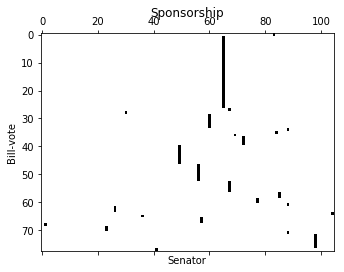

In [10]:
plt.spy(S)
plt.title('Sponsorship')
plt.xlabel('Senator')
plt.ylabel('Bill-vote');

Cosponsorship:

In [11]:
CS = np.zeros((N_BILLS_SEN, N_SENATORS))
for i, j in enumerate(bills_sen.cosponsors_sen):
    for k, l in enumerate(bills_sen.cosponsors_sen.iloc[i]):
        CS[i, list(members['member_id']).index(bills_sen.cosponsors_sen.iloc[i][k])] = 1

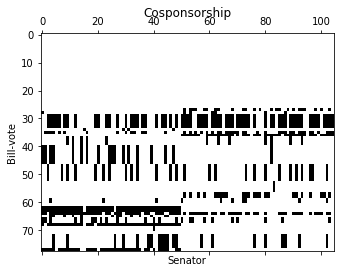

In [12]:
plt.spy(CS)
plt.title('Cosponsorship')
plt.xlabel('Senator')
plt.ylabel('Bill-vote');

In [13]:
Z = S + CS # sponsorship mask

Get votes for all senators for each of the bill-votes:

In [14]:
Y=np.zeros((N_BILLS_SEN, N_SENATORS))

for i, l in enumerate(list(bills_sen.vote_uri)):
    votes = (members.merge(votes_115[votes_115.vote_uri == l], how='left'))
    feature = votes.vote_position.apply(numeric_votes).values
    Y[i] = feature

Create train data using only votes from sponsors and cosponsors:

In [15]:
X = np.zeros((N_BILLS_SEN, N_SENATORS))
X[Z==1]=Y[Z==1]

In [16]:
n = X.shape[0]
d = X.shape[1]

print('n = {}\nd = {}'.format(n, d))

n = 78
d = 105


In [17]:
n_train = n//2
n_val = n//10

np.random.seed(321)
perm_idx = np.random.permutation(n)
X_train = X[perm_idx[:n_train]]
X_val = X[perm_idx[n_train:n_train+n_val]]
X_test = X[perm_idx[n_train+n_val:]]

y_train = Y[perm_idx[:n_train]]
y_val = Y[perm_idx[n_train:n_train+n_val]]
y_test = Y[perm_idx[n_train+n_val:]]


Create similarity graph (very dense, k=40):

In [18]:
dist, idx = graph.distance_scipy_spatial(votes_matrix.T, k=40, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)

In [19]:
def accuracy(pred, truth):
    not_vot = np.not_equal(truth, 0)
    a = np.equal(pred, truth)
    acc=np.sum(a[not_vot])/np.size(truth[not_vot])
    return acc

def build_pol_base(X, Laplacian, K):
    tX=[]
    for i in range(K):
        tX.append(np.array(X @ np.linalg.matrix_power(Laplacian, i)))
    return tX

def build_pol_base_exp(X, Laplacian, K, a):
    tX=[]
    for i in range(K):
        tX.append(np.array(X @ scipy.linalg.expm(k*a*Laplacian)))
    return tX

def get_reg_matrices(K, y, tX):
    M=np.zeros((K,K))
    Ym = np.zeros(K)
    for i in range(K):
        for j in range(K):
            M[i,j] = np.sum(tX[i] * tX[j])
        Ym[i] = np.sum(tX[i] * y)
    return M, Ym

def get_reg_matrices2(K, y, tX):
    D = y.shape[1]
    M= np.zeros((D*K, D*K))
    Ym = np.zeros(D*K)
    for i in range(K):
        for j in range(K):
            aux = np.sum(tX[i] * tX[j], axis = 0)
            np.fill_diagonal(M[D*i: D*(i+1),D*j: D*(j+1)], aux)
        Ym[D*i:D*(i+1)] = np.sum(tX[i] * y, axis = 0)
    return M, Ym

def train_ls(M, Ym):
    reg = linear_model.LinearRegression()
    reg.fit(M, Ym)
    theta = reg.coef_
    return theta

def predict(tX, theta):
    Pred = sum([theta[i]*j for i, j in enumerate(tX)])
    Pred_bool = (Pred-Pred.mean(axis=1)[:,np.newaxis])>0
    Pred[Pred_bool] = 1
    Pred[~Pred_bool] = -1
    return Pred

def predict2(tX, theta):
    Pred = sum([j@theta[i] for i, j in enumerate(tX)])
    Pred_bool = (Pred-Pred.mean(axis=1)[:,np.newaxis])>0
    Pred[Pred_bool] = 1
    Pred[~Pred_bool] = -1
    return Pred

In [20]:
Laplacian = graph.laplacian(A, normalized=True).todense()

### An example:

In [21]:
K = 4  # Filter parameters
tX = build_pol_base(X_train, Laplacian, K)
M, Ym = get_reg_matrices(K, y_train, tX)
theta = train_ls(M, Ym)
Pred = predict(tX, theta)
print('Accuracy train: ', accuracy(Pred, y_train))

Accuracy train:  0.7591719077568134


In [22]:
from matplotlib.colors import ListedColormap
mycmap = ListedColormap(['blue','white','red'])

Text(0.5,1,'Training truth')

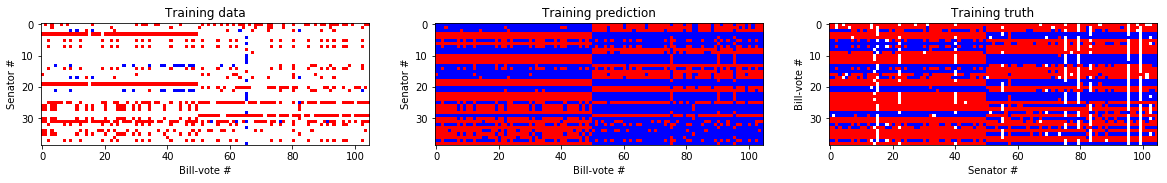

In [23]:
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_train, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Bill-vote #')
plt.ylabel('Senator #')
plt.title('Training data')
plt.subplot(1,3,2)
plt.imshow(Pred, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Bill-vote #')
plt.ylabel('Senator #')
plt.title('Training prediction')
plt.subplot(1,3,3)
plt.imshow(y_train, vmax = 1, vmin=-1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Training truth')


In [24]:
tX_test = build_pol_base(X_test, Laplacian, K)

Pred_test = predict(tX_test, theta)
print('Accuracy test: ', accuracy(Pred_test, y_test))

Accuracy test:  0.7899746192893401


Text(0.5,1,'Test truth')

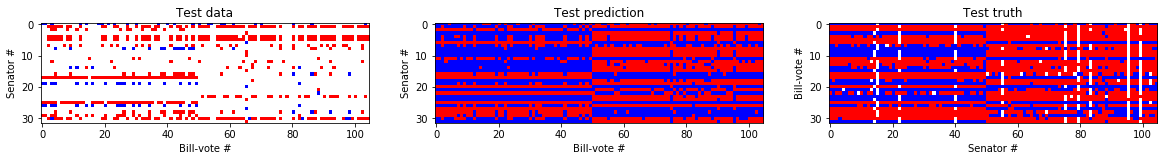

In [25]:
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Bill-vote #')
plt.ylabel('Senator #')
plt.title('Test data')
plt.subplot(1,3,2)
plt.imshow(Pred_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Bill-vote #')
plt.ylabel('Senator #')
plt.title('Test prediction')
plt.subplot(1,3,3)
plt.imshow(y_test, vmax = 1, vmin=-1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test truth')

### Model 1:

Estimate the polynomial graph filter $f(L) = \sum^K_k \alpha_k L^k$ using least squares:
1. Solve: 
$$\min_{\alpha}\left\Vert Y-\sum^K_{k=0} \alpha_k L^k X\right\Vert^2$$

In [26]:
acc_test = []
acc_train = []
k_vec = range(2, 200)
for k in k_vec:
    tX_train = build_pol_base(X_train, Laplacian, k)
    M, Ym = get_reg_matrices(k, y_train, tX_train)
    theta = train_ls(M, Ym)
    tX_test = build_pol_base(X_test, Laplacian, k)
    Pred_test = predict(tX_test, theta)
    Pred_train = predict(tX_train, theta)
    acc_train.append(accuracy(Pred_train, y_train))
    acc_test.append(accuracy(Pred_test, y_test))

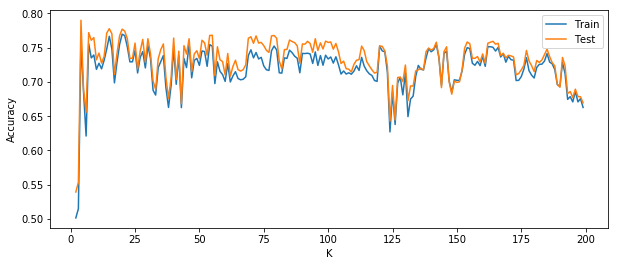

In [27]:
plt.figure(figsize=(10,4))
plt.plot(k_vec, acc_train)
plt.plot(k_vec, acc_test)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])

In [28]:
print(np.max(acc_test))
print(np.argmax(acc_test))

0.7899746192893401
2


### Model 2:

Estimate the polynomial graph filter $f(L) = \sum^K_k A_k L^k$ using least squares:
1. Solve: 
$$\min_{A}\left\Vert Y-\sum^K_{k=0} A_k L^k X\right\Vert^2$$

where $A_k = diag(\alpha_{1k},\dots, \alpha_{Dk})$.

In [29]:
def make_Theta(K, D, theta):
    Theta = []
    for i in range(K):
        Theta.append(np.diag(theta[i*D: (i+1)*D]))
    return Theta

In [30]:
acc_test = []
acc_train = []
k_vec = range(2, 50)
for k in k_vec:
    tX_train = build_pol_base(X_train, Laplacian, k)
    M, Ym = get_reg_matrices2(k, y_train, tX_train)
    theta = train_ls(M, Ym)
    Theta = make_Theta(k, y_train.shape[1], theta)
    tX_test = build_pol_base(X_test, Laplacian, k)
    Pred_test = predict2(tX_test, Theta)
    Pred_train = predict2(tX_train, Theta)
    acc_train.append(accuracy(Pred_train, y_train))
    acc_test.append(accuracy(Pred_test, y_test))

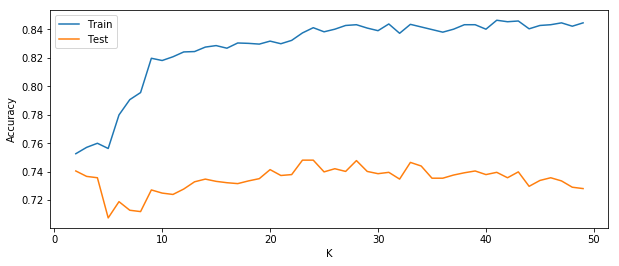

In [31]:
plt.figure(figsize=(10,4))
plt.plot(k_vec, acc_train)
plt.plot(k_vec, acc_test)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])

In [32]:
print(np.max(acc_test))
print(np.argmax(acc_test))

0.7480964467005076
21


### Model 3:

Estimate the polynomial graph filter $f(L) = \sum^K_k \alpha_k e^{k\tau L}$ using least squares:
1. Solve: 
$$\min_{\alpha}\left\Vert Y-\sum^K_{k=0} \alpha_k e^{k\tau L} X\right\Vert^2$$


In [33]:
a_vec= np.logspace(-5, 0, 20)
acc_test = []
acc_train = []
k_vec = range(2, 50)
for a in a_vec:
    for k in k_vec:
        tX_train = build_pol_base_exp(X_train, Laplacian, k, a)
        M, Ym = get_reg_matrices(k, y_train, tX_train)
        theta = train_ls(M, Ym)
        tX_test = build_pol_base_exp(X_test, Laplacian, k, a)
        Pred_test = predict(tX_test, theta)
        Pred_train = predict(tX_train, theta)
        acc_train.append(accuracy(Pred_train, y_train))
        acc_test.append(accuracy(Pred_test, y_test))

In [34]:
acc_train_ = np.array(acc_train).reshape(len(a_vec),len(k_vec))
acc_test_ = np.array(acc_test).reshape(len(a_vec),len(k_vec))

Text(0.5,1,'Test accuracy')

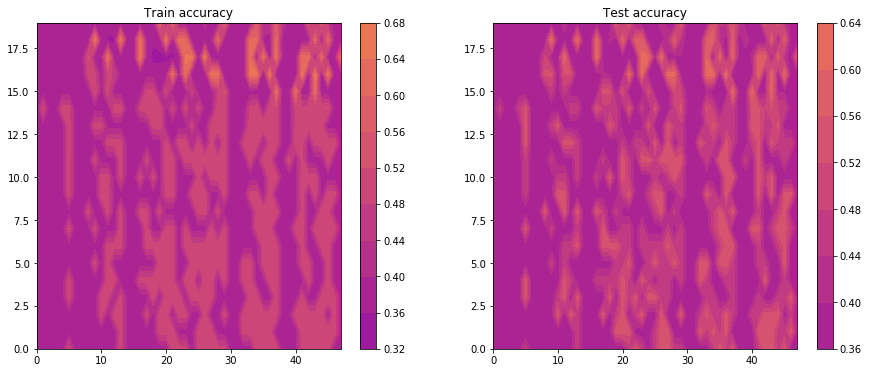

In [35]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
im1 = ax[0].contourf(acc_train_, vmin = 0, vmax = 1,cmap ='plasma')
im2 = ax[1].contourf(acc_test_, vmin = 0, vmax = 1, cmap = 'plasma')
plt.colorbar(im1, ax = ax[0])
plt.colorbar(im2, ax = ax[1])
ax[0].set_title('Train accuracy')
ax[1].set_title('Test accuracy')


In [36]:
np.max(acc_test_)

0.6161167512690355